In [3]:
import os
import numpy as np

# Function to extract Cα coordinates from a PDB file
def extract_ca_coordinates(pdb_file, chainID):
    ca_coords = []
    
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith("ATOM") and " CA " in line and line[21] == chainID:
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                ca_coords.append([x, y, z])
    
    return np.array(ca_coords)

# Function to calculate the RMSF for each residue
def calculate_rmsf(aligned_coords):
    n_structures = len(aligned_coords)
    average_coords = np.mean(aligned_coords, axis=0)  # Mean coordinates per residue
    
    # Calculate RMSF per residue
    rmsf = np.sqrt(np.mean(np.sum((aligned_coords - average_coords)**2, axis=2), axis=0))
    return rmsf

# Function to superpose structures to a reference structure
def superpose_structures(ref_coords, target_coords):
    # Perform a Kabsch algorithm-based superposition
    ref_center = np.mean(ref_coords, axis=0)
    target_center = np.mean(target_coords, axis=0)

    ref_centered = ref_coords - ref_center
    target_centered = target_coords - target_center

    H = np.dot(target_centered.T, ref_centered)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    aligned_coords = np.dot(target_centered, R) + ref_center
    return aligned_coords

# Process all PDB files and calculate RMSF
def calculate_rmsf_for_recycles(folder, model_number, model_seed, chainID='A'):
    coords_per_recycle = []

    # Iterate over recycles 0 to 12
    for r in range(13):
        pdb_file = None
        # Look for the corresponding PDB file for the specified model number, recycle, and seed
        for filename in os.listdir(folder):
            if (filename.endswith(".pdb") and 
                f'model_{model_number}_ptm_r{r}_seed{model_seed}' in filename):
                pdb_file = os.path.join(folder, filename)
                break

        if pdb_file is None:
            print(f"PDB file for recycle {r} with model {model_number} and seed {model_seed} not found.")
            continue
        
        # Extract Cα coordinates
        ca_coords = extract_ca_coordinates(pdb_file, chainID)
        coords_per_recycle.append(ca_coords)
    
    if not coords_per_recycle:
        print("No valid structures found.")
        return None

    # Use the first structure (recycle 0) as the reference
    ref_coords = coords_per_recycle[0]
    aligned_coords = []

    # Superpose each structure to the reference
    for coords in coords_per_recycle:
        aligned = superpose_structures(ref_coords, coords)
        aligned_coords.append(aligned)
    
    # Convert aligned coordinates to a numpy array
    aligned_coords = np.array(aligned_coords)

    # Calculate RMSF for each residue
    rmsf = calculate_rmsf(aligned_coords)
    return rmsf

# Plot RMSF
def plot_rmsf(rmsf, model_number, model_seed):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(rmsf, marker='o', linestyle='-', color='blue')
    plt.title(f'RMSF per Residue (Recycle 0 to 12) for Model {model_number}, Seed {model_seed}', fontsize=15)
    plt.xlabel('Residue Index', fontsize=12)
    plt.ylabel('RMSF (Å)', fontsize=12)
    plt.grid(True)
    plt.show()



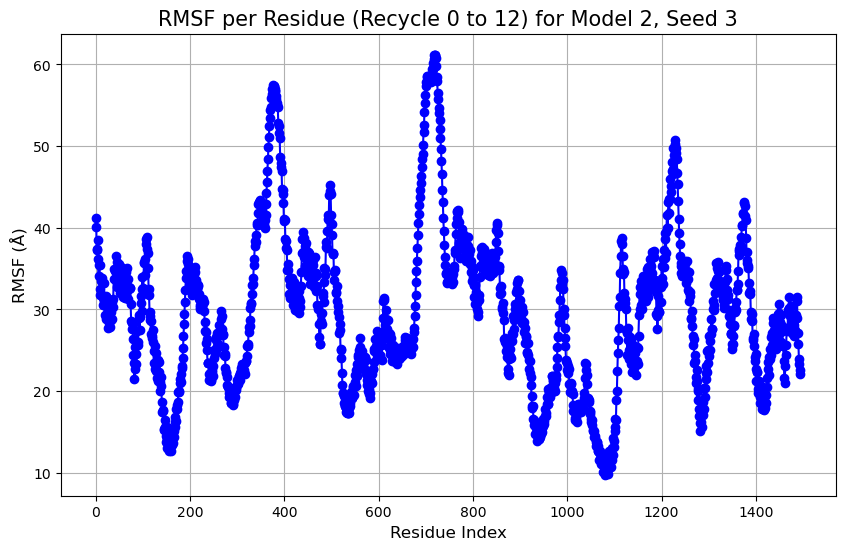

In [4]:
# Usage example
#folder_path = '/Users/adrianahernandezgonzalez/LabNotebook/10-24/states/partialAlphaCaV12HS8HLPlocalrun_b3702_32_64_10/pdb'
folder = '/Users/adrianahernandezgonzalez/LabNotebook/10-24/states/partialAlphaCaV12HS8HLPlocalrun_b3702_8_16_10/pdb/'  # Replace with the path to your folder containing PDB files
model_number = '2'  # Replace with the specific model number (e.g., '1')
model_seed = '3'      # Replace with the specific model seed (e.g., '1')
rmsf_values = calculate_rmsf_for_recycles(folder, model_number, model_seed, chainID='A')



if rmsf_values is not None:
    plot_rmsf(rmsf_values, model_number, model_seed)


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to extract Cα coordinates from a PDB file
def extract_ca_coordinates(pdb_file, chainID):
    ca_coords = []
    
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith("ATOM") and " CA " in line and line[21] == chainID:
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                ca_coords.append([x, y, z])
    
    return np.array(ca_coords)

# Function to superpose structures to a reference structure
def superpose_structures(ref_coords, target_coords):
    # Perform a Kabsch algorithm-based superposition
    ref_center = np.mean(ref_coords, axis=0)
    target_center = np.mean(target_coords, axis=0)

    ref_centered = ref_coords - ref_center
    target_centered = target_coords - target_center

    H = np.dot(target_centered.T, ref_centered)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    aligned_coords = np.dot(target_centered, R) + ref_center
    return aligned_coords

# Function to calculate the RMSF for each residue
def calculate_rmsf(aligned_coords):
    n_structures = len(aligned_coords)
    average_coords = np.mean(aligned_coords, axis=0)  # Mean coordinates per residue
    
    # Calculate RMSF per residue
    rmsf = np.sqrt(np.mean(np.sum((aligned_coords - average_coords)**2, axis=2), axis=0))
    return rmsf

# Function to compute RMSF for a single recycle
def compute_rmsf_for_recycle(folder, model_number, model_seed, recycle, chainID='A'):
    # Look for the corresponding PDB file
    pdb_file = None
    for filename in os.listdir(folder):
        if (filename.endswith(".pdb") and 
            f'model_{model_number}_ptm_r{recycle}_seed{model_seed}' in filename):
            pdb_file = os.path.join(folder, filename)
            break

    if pdb_file is None:
        print(f"PDB file for recycle {recycle} with model {model_number} and seed {model_seed} not found.")
        return None
    
    # Extract Cα coordinates
    ca_coords = extract_ca_coordinates(pdb_file, chainID)
    return ca_coords

# Function to calculate RMSF differences between successive recycles
def analyze_rmsf_changes(folder, model_number, model_seed, chainID='A'):
    rmsf_differences = []
    recycle_pairs = []
    
    # Iterate from recycle 0 to 11 (analyzing successive pairs)
    for r in range(12):
        coords_1 = compute_rmsf_for_recycle(folder, model_number, model_seed, r, chainID)
        coords_2 = compute_rmsf_for_recycle(folder, model_number, model_seed, r + 1, chainID)
        
        if coords_1 is None or coords_2 is None:
            continue
        
        # Superpose both structures to the reference (coords_1)
        aligned_1 = superpose_structures(coords_1, coords_1)  # self-alignment for consistency
        aligned_2 = superpose_structures(coords_1, coords_2)  # align coords_2 to coords_1
        
        # Calculate RMSF for the aligned structures
        aligned_coords = np.array([aligned_1, aligned_2])
        rmsf = calculate_rmsf(aligned_coords)
        
        # Calculate the difference in RMSF between the two recycles
        rmsf_differences.append(rmsf)
        recycle_pairs.append((r, r + 1))
    
    return rmsf_differences, recycle_pairs

# Plot RMSF Differences for Successive Recycles
def plot_rmsf_differences(rmsf_differences, recycle_pairs):
    plt.figure(figsize=(12, 8))
    
    # Plot each difference for the recycle pairs
    for i, (rmsf_diff, (r1, r2)) in enumerate(zip(rmsf_differences, recycle_pairs)):
        plt.plot(rmsf_diff, marker='o', linestyle='-', label=f'Recycle {r1} to {r2}')
    
    plt.title('RMSF Differences Between Successive Recycles', fontsize=15)
    plt.xlabel('Residue Index', fontsize=12)
    plt.ylabel('RMSF Difference (Å)', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()



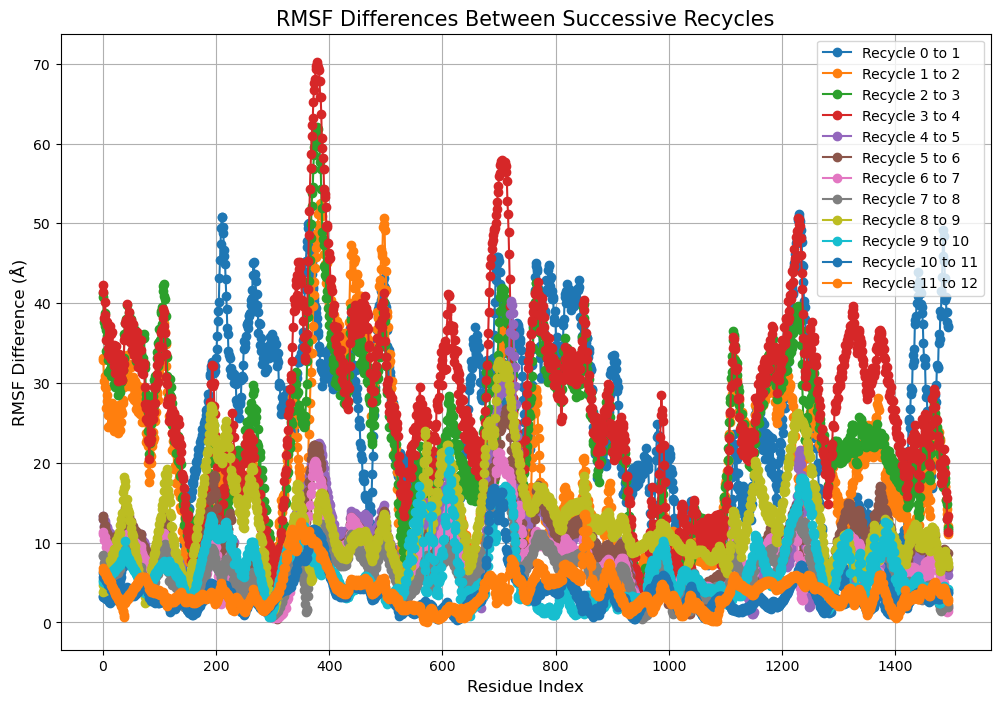

In [6]:
# Usage example
folder = '/Users/adrianahernandezgonzalez/LabNotebook/10-24/states/partialAlphaCaV12HS8HLPlocalrun_b3702_8_16_10/pdb/'  # Replace with the path to your folder containing PDB files
model_number = '2'  # Replace with the specific model number (e.g., '1')
model_seed = '3'      # Replace with the specific model seed (e.g., '1')

# Analyze RMSF changes between successive recycles
rmsf_differences, recycle_pairs = analyze_rmsf_changes(folder, model_number, model_seed, chainID='A')

# Plot the differences
if rmsf_differences:
    plot_rmsf_differences(rmsf_differences, recycle_pairs)


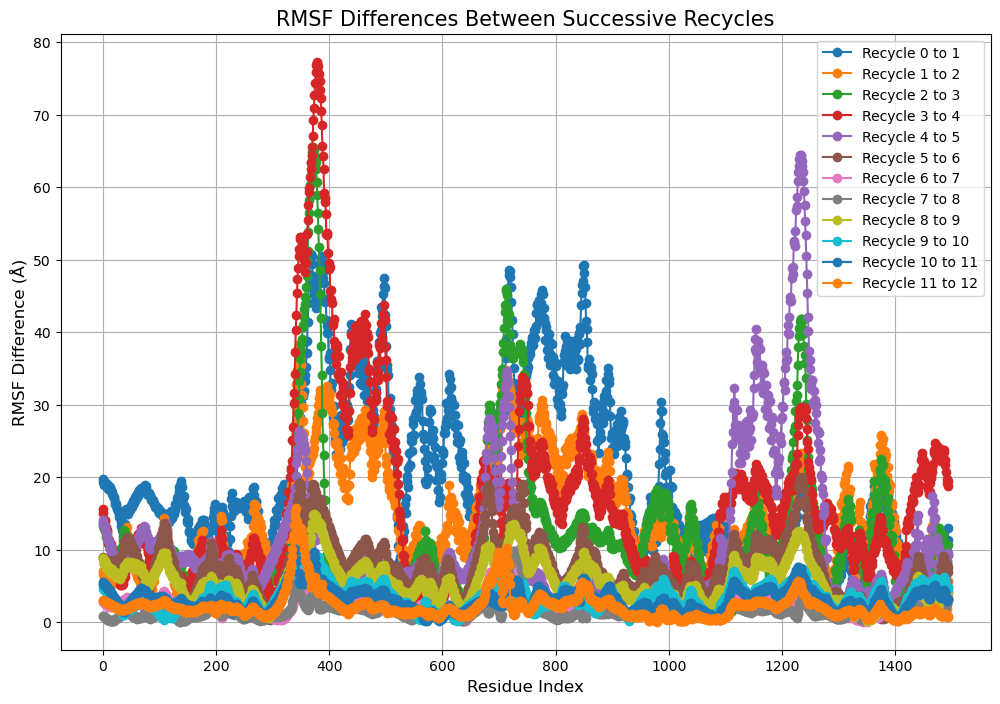

In [7]:
# Usage example
folder = '/Users/adrianahernandezgonzalez/LabNotebook/10-24/states/partialAlphaCaV12HS8HLPlocalrun_b3702_32_64_10/pdb/'  # Replace with the path to your folder containing PDB files
model_number = '2'  # Replace with the specific model number (e.g., '1')
model_seed = '3'      # Replace with the specific model seed (e.g., '1')

# Analyze RMSF changes between successive recycles
rmsf_differences, recycle_pairs = analyze_rmsf_changes(folder, model_number, model_seed, chainID='A')

# Plot the differences
if rmsf_differences:
    plot_rmsf_differences(rmsf_differences, recycle_pairs)


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to extract Cα coordinates from a PDB file
def extract_ca_coordinates(pdb_file, chainID):
    ca_coords = []
    
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith("ATOM") and " CA " in line and line[21] == chainID:
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                ca_coords.append([x, y, z])
    
    return np.array(ca_coords)

# Function to superpose structures to a reference structure
def superpose_structures(ref_coords, target_coords):
    # Perform a Kabsch algorithm-based superposition
    ref_center = np.mean(ref_coords, axis=0)
    target_center = np.mean(target_coords, axis=0)

    ref_centered = ref_coords - ref_center
    target_centered = target_coords - target_center

    H = np.dot(target_centered.T, ref_centered)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    aligned_coords = np.dot(target_coords - target_center, R) + ref_center
    return aligned_coords

# Function to calculate RMSF for each residue over recycles
def calculate_rmsf_over_recycles(folder, model_number, model_seed, chainID='A'):
    rmsf_per_recycle = []

    # Use recycle 0 as the reference
    ref_coords = None
    for filename in os.listdir(folder):
        if filename.endswith(".pdb") and f'model_{model_number}_ptm_r0_seed{model_seed}' in filename:
            ref_coords = extract_ca_coordinates(os.path.join(folder, filename), chainID)
            break

    if ref_coords is None:
        print(f"Reference PDB for recycle 0 not found for model {model_number} and seed {model_seed}.")
        return None

    # Calculate RMSF for each recycle
    for r in range(13):
        pdb_file = None
        for filename in os.listdir(folder):
            if filename.endswith(".pdb") and f'model_{model_number}_ptm_r{r}_seed{model_seed}' in filename:
                pdb_file = os.path.join(folder, filename)
                break

        if pdb_file is None:
            print(f"PDB file for recycle {r} with model {model_number} and seed {model_seed} not found.")
            continue

        # Extract Cα coordinates
        target_coords = extract_ca_coordinates(pdb_file, chainID)

        # Superpose to the reference coordinates (recycle 0)
        aligned_coords = superpose_structures(ref_coords, target_coords)
        
        # Calculate RMSF for this recycle
        rmsf = np.sqrt(np.mean(np.sum((aligned_coords - ref_coords)**2, axis=1)))
        rmsf_per_recycle.append(rmsf)
    
    return rmsf_per_recycle

# Plot RMSF Changes Over Recycles
def plot_rmsf_change_over_recycles(rmsf_per_recycle, model_number, model_seed):
    recycles = list(range(len(rmsf_per_recycle)))
    
    plt.figure(figsize=(10, 6))
    plt.plot(recycles, rmsf_per_recycle, marker='o', linestyle='-', color='green')
    plt.title(f'RMSF Change Over Recycles for Model {model_number}, Seed {model_seed}', fontsize=15)
    plt.xlabel('Recycle Number', fontsize=12)
    plt.ylabel('Average RMSF (Å)', fontsize=12)
    plt.grid(True)
    plt.show()



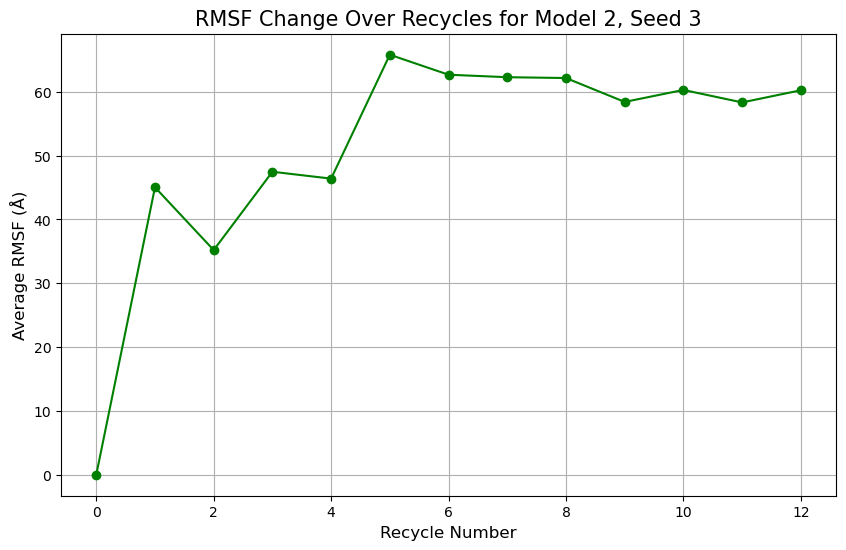

In [10]:
# Usage example
folder = '/Users/adrianahernandezgonzalez/LabNotebook/10-24/states/partialAlphaCaV12HS8HLPlocalrun_b3702_32_64_10/pdb/'  # Replace with the path to your folder containing PDB files
model_number = '2'  # Replace with the specific model number (e.g., '1')
model_seed = '3'      # Replace with the specific model seed (e.g., '1')

# Calculate RMSF changes over recycles
rmsf_per_recycle = calculate_rmsf_over_recycles(folder, model_number, model_seed, chainID='A')

# Plot the changes if calculation was successful
if rmsf_per_recycle is not None:
    plot_rmsf_change_over_recycles(rmsf_per_recycle, model_number, model_seed)


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to extract Cα coordinates from a PDB file
def extract_ca_coordinates(pdb_file, chainID):
    ca_coords = []
    
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith("ATOM") and " CA " in line and line[21] == chainID:
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                ca_coords.append([x, y, z])
    
    return np.array(ca_coords)

# Function to superpose structures to a reference structure
def superpose_structures(ref_coords, target_coords):
    # Perform a Kabsch algorithm-based superposition
    ref_center = np.mean(ref_coords, axis=0)
    target_center = np.mean(target_coords, axis=0)

    ref_centered = ref_coords - ref_center
    target_centered = target_coords - target_center

    H = np.dot(target_centered.T, ref_centered)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    aligned_coords = np.dot(target_coords - target_center, R) + ref_center
    return aligned_coords

# Function to calculate RMSF for each recycle
def calculate_rmsf_over_recycles(folder, model_number, model_seed, chainID='A'):
    rmsf_per_recycle = []

    # Use recycle 0 as the reference
    ref_coords = None
    for filename in os.listdir(folder):
        if filename.endswith(".pdb") and f'model_{model_number}_ptm_r0_seed{model_seed}' in filename:
            ref_coords = extract_ca_coordinates(os.path.join(folder, filename), chainID)
            break

    if ref_coords is None:
        print(f"Reference PDB for recycle 0 not found for model {model_number} and seed {model_seed}.")
        return None

    # Calculate RMSF for each recycle
    for r in range(13):
        pdb_file = None
        for filename in os.listdir(folder):
            if filename.endswith(".pdb") and f'model_{model_number}_ptm_r{r}_seed{model_seed}' in filename:
                pdb_file = os.path.join(folder, filename)
                break

        if pdb_file is None:
            print(f"PDB file for recycle {r} with model {model_number} and seed {model_seed} not found.")
            continue

        # Extract Cα coordinates
        target_coords = extract_ca_coordinates(pdb_file, chainID)

        # Superpose to the reference coordinates (recycle 0)
        aligned_coords = superpose_structures(ref_coords, target_coords)
        
        # Calculate RMSF for this recycle
        rmsf = np.sqrt(np.mean(np.sum((aligned_coords - ref_coords)**2, axis=1)))
        rmsf_per_recycle.append(rmsf)
    
    return rmsf_per_recycle

# Function to calculate absolute delta RMSF between successive recycles
def calculate_absolute_delta_rmsf(rmsf_per_recycle):
    # Ensure the differences are calculated as absolute values
    absolute_delta_rmsf = [abs(rmsf_per_recycle[i+1] - rmsf_per_recycle[i]) for i in range(len(rmsf_per_recycle) - 1)]
    return absolute_delta_rmsf

# Plot Absolute Delta RMSF Over Recycles
def plot_absolute_delta_rmsf(absolute_delta_rmsf, model_number, model_seed):
    recycles = list(range(1, len(absolute_delta_rmsf) + 1))  # Delta starts from recycle 1 (difference with previous)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recycles, absolute_delta_rmsf, marker='o', linestyle='-', color='purple')
    plt.title(f'Absolute Delta RMSF Over Recycles for Model {model_number}, Seed {model_seed}', fontsize=15)
    plt.xlabel('Recycle Number', fontsize=12)
    plt.ylabel('Absolute Delta RMSF (Å)', fontsize=12)
    plt.grid(True)
    plt.show()


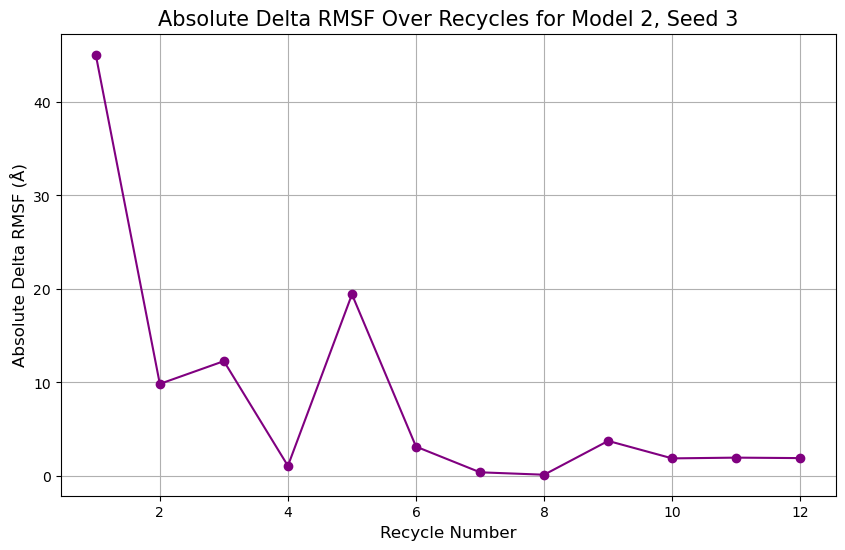

In [18]:

# Usage example
folder = '/Users/adrianahernandezgonzalez/LabNotebook/10-24/states/partialAlphaCaV12HS8HLPlocalrun_b3702_32_64_10/pdb/'  # Replace with the path to your folder containing PDB files
model_number = '2'  # Replace with the specific model number (e.g., '1')
model_seed = '3'      # Replace with the specific model seed (e.g., '1')


# Calculate RMSF changes over recycles
rmsf_per_recycle = calculate_rmsf_over_recycles(folder, model_number, model_seed, chainID='A')

# Calculate absolute delta RMSF if calculation was successful
if rmsf_per_recycle is not None and len(rmsf_per_recycle) > 1:
    absolute_delta_rmsf = calculate_absolute_delta_rmsf(rmsf_per_recycle)
    plot_absolute_delta_rmsf(absolute_delta_rmsf, model_number, model_seed)
